<a href="https://colab.research.google.com/github/mvsakrishna/AIM-5001/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
from transformers import AutoTokenizer
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

In [3]:
!pip install nltk
!pip install audio-diffusion-pytorch
!pip install git+https://github.com/archinetai/audio-diffusion-pytorch

  Cloning https://github.com/archinetai/audio-diffusion-pytorch to /tmp/pip-req-build-gem2bn84
  Running command git clone --filter=blob:none --quiet https://github.com/archinetai/audio-diffusion-pytorch /tmp/pip-req-build-gem2bn84
  Resolved https://github.com/archinetai/audio-diffusion-pytorch to commit f4052e321c820e467e51e14d005f3d0077997278
  Preparing metadata (setup.py) ... done


In [4]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [5]:
!pip install --upgrade pyfluidsynth

In [6]:
!pip install pretty_midi

In [7]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [8]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [9]:
import torchaudio
import torch
from torchaudio.transforms import Resample
from tqdm import tqdm
import os

# Set the path to the folder containing audio files
audio_folder = '/content/drive/MyDrive/data_audio'

# Initialize an empty list to store the tensors
waveform_list = []

# Specify the desired sample rate (adjust as needed)
desired_sample_rate = 44

# Iterate through audio files in the folder
for audio_file in tqdm(os.listdir(audio_folder)):
    if audio_file.endswith(('.wav', '.mp3')):
        audio_path = os.path.join(audio_folder, audio_file)
        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)
        # If needed, resample the waveform to the desired sample rate
        resample = Resample(orig_freq=sample_rate, new_freq=desired_sample_rate)
        waveform = resample(waveform)
        # Append the waveform to the list
        waveform_list.append(waveform)

# Concatenate the waveforms along the time dimension
audio_data = torch.cat(waveform_list, dim=-1)

# Display information about the resulting tensor
print("Audio Data:", audio_data)
print("Audio Data Shape:", audio_data.shape)


100%|██████████| 76/76 [00:31<00:00,  2.42it/s]

Audio Data: tensor([[-0.0017,  0.0261,  0.0014,  ...,  0.0091,  0.0167, -0.0452],
        [-0.0014,  0.0310,  0.0068,  ...,  0.0081,  0.0151, -0.0393]])
Audio Data Shape: torch.Size([2, 196652])


In [10]:
data_text = '/content/drive/MyDrive/data_text.txt'

with open(data_text, 'r') as file:
    text_data = file.read().splitlines()

print(text_data)

['Electro House (Remix), 2023, 3 of 4', 'Hardstyle, Drop, 8D, Remix, High Quality, 2 of 4', 'African Drums, Rythm, (Deluxe Edition), 2 of 4', 'Electro Swing Remix 2030 (High Quality) (Deluxe Edition) 3 of 4', 'EDM, Vocal, Relax, Remix, 2023, 8D Audio', 'Death Metal, 2012', 'Egyptian Darbuka, Drums, Rythm, (Deluxe Edition), 2 of 4', 'Dubstep Insane Drop Remix (Deluxe Edition), 2 of 4', 'Future Bass, EDM (Remix) 3 of 4, Remix', 'Heavy metal (Deluxe Edition) 1 of 2', 'Italian Hip Hop 2022 (Deluxe Edition) 3 of 4', 'Guitar Bass Solo Hard Rock (High Quality) 2 of 3', 'Hip Hop, Rap Battle, 2018 (High Quality) (Deluxe Edition) 3 of 4', 'African Drums, Electro Remix 2023 (High Quality) (Deluxe Edition) 3 of 4 ', 'Drum and bass, electro remix (High Quality) (Deluxe Edition) 2 of 4', 'Future bass, drum and bass, electro remix (High Quality) (Deluxe Edition) 2 of 4', 'Downtempo (Remix), High Quality, Deluxe Exition 2023, 2 of 4', 'Retro Synthwave (Remix), 2023, 2 of 4', 'Dance Electronic Remix, 2

In [11]:
!pip install --upgrade pyarrow
!pip install torchtext
!pip install torchaudio tqdm

In [12]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Tokenize the text data
tokenized_text_data = [text.split() for text in text_data]

# Build vocabulary
vocab = set(word for tokens in tokenized_text_data for word in tokens)
vocab_size = len(vocab)
word_to_index = {word: index for index, word in enumerate(vocab)}

# Numericalize the text data
numericalized_text_data = [
    torch.tensor([word_to_index[word] for word in tokens], dtype=torch.long)
    for tokens in tokenized_text_data
]

# Pad sequences to make them of equal length
padded_text_data = pad_sequence(numericalized_text_data, batch_first=True, padding_value=0)  # Assuming 0 is the index for '<pad>'

# Convert to PyTorch tensor
tensor_text_data = padded_text_data.clone().detach().to(torch.long)


In [13]:
print(tensor_text_data)
print("Tensor Shape:", tensor_text_data.shape)

tensor([[172, 211, 297,  ...,   0,   0,   0],
        [185, 330,  87,  ...,   0,   0,   0],
        [ 63, 194, 338,  ...,   0,   0,   0],
        ...,
        [ 85,   2, 122,  ...,   0,   0,   0],
        [298, 239, 359,  ...,   0,   0,   0],
        [  4, 239, 272,  ...,   0,   0,   0]])
Tensor Shape: torch.Size([87, 35])


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [15]:
num_samples = 5

In [16]:
text_data = torch.randint(0, 500, (num_samples, 35), dtype=torch.long)
audio_data = torch.randn(num_samples, 1, 197080693)
target_music = torch.randn(num_samples, 1, 197080693)

In [17]:
batch_size = 16  # Adjust based on your available RAM
dataset = TensorDataset(text_data, audio_data, target_music)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
# Define your model architecture
class TextToMusicModel(nn.Module):
    def __init__(self, text_embedding_dim, audio_embedding_dim):
        super(TextToMusicModel, self).__init__()
        self.text_embedding = nn.EmbeddingBag(num_embeddings=500, embedding_dim=text_embedding_dim, sparse=True)
        self.audio_embedding = nn.Linear(audio_embedding_dim, 128)
        self.fc1 = nn.Linear(text_embedding_dim + 128, 512)
        self.fc2 = nn.Linear(512, 1 * 197080693)  # Assuming 1 channel for output music

    def forward(self, text_data, audio_data):
        text_embedding = self.text_embedding(text_data)
        audio_embedding = self.audio_embedding(audio_data)
        concatenated_data = torch.cat((text_embedding, audio_embedding), dim=1)
        output_music = self.fc2(self.fc1(concatenated_data))
        return output_music

In [19]:
embedding_dim_text = 10
embedding_dim_audio = 1  # Assuming 1 channel for audio data
learning_rate = 0.001

In [20]:
model = TextToMusicModel(text_embedding_dim=embedding_dim_text, audio_embedding_dim=embedding_dim_audio)

In [22]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

NameError: name 'model' is not defined

In [23]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    output_music = model(text_data, audio_data)

    # Compute loss
    loss = criterion(output_music, target_music)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress or other metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# After training, you can use the trained model for generating music from text or other tasks.

NameError: name 'model' is not defined

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back into a string
    processed_text = ' '.join(words)

    return processed_text

data_text = '/content/drive/MyDrive/data_text.txt'

with open(data_text, 'r') as file:
    text_data = file.read()

# Apply text preprocessing
processed_text_data = preprocess_text(text_data)

print(processed_text_data)

electro hous remix 2023 3 4 hardstyl drop 8d remix high qualiti 2 4 african drum rythm delux edit 2 4 electro swing remix 2030 high qualiti delux edit 3 4 edm vocal relax remix 2023 8d audio death metal 2012 egyptian darbuka drum rythm delux edit 2 4 dubstep insan drop remix delux edit 2 4 futur bass edm remix 3 4 remix heavi metal delux edit 1 2 italian hip hop 2022 delux edit 3 4 guitar bass solo hard rock high qualiti 2 3 hip hop rap battl 2018 high qualiti delux edit 3 4 african drum electro remix 2023 high qualiti delux edit 3 4 drum bass electro remix high qualiti delux edit 2 4 futur bass drum bass electro remix high qualiti delux edit 2 4 downtempo remix high qualiti delux exit 2023 2 4 retro synthwav remix 2023 2 4 danc electron remix 2023 2 4 1989 claud symphoniqu de dutoit prelud faun classic 2 4 organ symphoni poulenc organ concerto symphoni 3 c minor op 78 organ symphoni iib maestoso allegro molto allegro 2006 2 4 hummel trumpet concerto e flat iii rondo 4 4 wolfgang amade

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
import re

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back into a string
    cleaned_text = ' '.join(words)

    return cleaned_text


# Apply text cleaning
cleaned_text_data = clean_text(processed_text_data)

print(cleaned_text_data)


electro hou remix hardstyl drop remix high qualiti african drum rythm delux edit electro swing remix high qualiti delux edit edm vocal relax remix audio death metal egyptian darbuka drum rythm delux edit dubstep insan drop remix delux edit futur bass edm remix remix heavi metal delux edit italian hip hop delux edit guitar bass solo hard rock high qualiti hip hop rap battl high qualiti delux edit african drum electro remix high qualiti delux edit drum bass electro remix high qualiti delux edit futur bass drum bass electro remix high qualiti delux edit downtempo remix high qualiti delux exit retro synthwav remix danc electron remix claud symphoniqu de dutoit prelud faun classic organ symphoni poulenc organ concerto symphoni c minor op organ symphoni iib maestoso allegro molto allegro hummel trumpet concerto e flat iii rondo wolfgang amadeu martin nevil marrin amadeu classic classic amadeu wolfgang amadeu martin nevil marrin wolfgang amadeu chamber orchestra classic serenad major gran par

In [26]:
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Tokenize and preprocess the text data
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Assuming 'cleaned_text_data' is your cleaned text data
tokenized_data = [preprocess_text(text) for text in cleaned_text_data]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_data]

# Apply LDA
num_topics = 5  # Adjust the number of topics as needed
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id + 1}: {topic_words}")

# Get the topic distribution for each document
topic_distribution = [lda_model[doc] for doc in corpus]

# Assign the most dominant topic to each document
dominant_topic = [max(doc, key=lambda x: x[1])[0] for doc in topic_distribution]

# Now 'dominant_topic' contains the assigned topic for each document

Topic 1: 0.415*"p" + 0.364*"h" + 0.170*"g" + 0.042*"w" + 0.001*"r" + 0.001*"e" + 0.001*"u" + 0.001*"n" + 0.001*"q" + 0.001*"v"
Topic 2: 0.593*"n" + 0.361*"x" + 0.033*"z" + 0.001*"p" + 0.001*"c" + 0.001*"g" + 0.001*"j" + 0.001*"e" + 0.001*"q" + 0.001*"u"
Topic 3: 0.528*"r" + 0.337*"u" + 0.100*"v" + 0.028*"j" + 0.001*"g" + 0.001*"f" + 0.001*"q" + 0.001*"e" + 0.001*"c" + 0.001*"h"
Topic 4: 0.661*"l" + 0.129*"f" + 0.118*"b" + 0.082*"k" + 0.001*"r" + 0.001*"e" + 0.001*"v" + 0.001*"g" + 0.001*"q" + 0.001*"c"
Topic 5: 0.690*"e" + 0.258*"c" + 0.044*"q" + 0.001*"l" + 0.001*"p" + 0.001*"z" + 0.001*"r" + 0.001*"u" + 0.001*"w" + 0.001*"j"


In [27]:
import pandas as pd
import os

audio_folder = '/content/drive/MyDrive/musicnet/test_data'
label_folder = '/content/drive/MyDrive/musicnet/test_labels'

# List all label and audio files
label_files = [os.path.join(label_folder, file) for file in os.listdir(label_folder) if file.endswith('.csv')]
audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith('.wav')]

# Create an empty list to store rows
rows = []

# Iterate through label and audio files and populate the list
for label_file in label_files:
    # Get the corresponding audio file
    audio_file = os.path.join(audio_folder, os.path.basename(label_file).replace('.csv', '.wav'))

    # Check if the corresponding audio file exists
    if os.path.exists(audio_file):
        # Read label data
        label_data = pd.read_csv(label_file)

        # Extract relevant columns from label data
        label_info = label_data[['start_time', 'end_time', 'instrument', 'note', 'start_beat', 'end_beat', 'note_value']]

        # Append data to the list along with the audio file path
        rows.append({
            'start_time': label_info['start_time'].tolist(),
            'end_time': label_info['end_time'].tolist(),
            'instrument': label_info['instrument'].tolist(),
            'note': label_info['note'].tolist(),
            'start_beat': label_info['start_beat'].tolist(),
            'end_beat': label_info['end_beat'].tolist(),
            'note_value': label_info['note_value'].tolist(),
            'Audio': audio_file
        })
    else:
        print(f"Warning: No corresponding audio file found for label file: {label_file}")

# Create a DataFrame from the list of rows
combined_df = pd.DataFrame(rows)

pd.set_option('display.max_colwidth', None)
print(combined_df)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             start_time  \
0  [99294, 105950, 112606, 119262, 125918, 132574, 139230, 145374, 152030, 159710, 165342, 172510, 180190, 186334, 192990, 198622, 205278, 211422, 216542, 224222, 259038, 265182, 272350, 27

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [30]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [31]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2017/MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--3.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [32]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [33]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [34]:
display_audio(pm)

In [46]:
import pretty_midi

# Create a PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI()

# Create an Instrument object
instrument = pretty_midi.Instrument(program=0)

# Add some notes to the instrument
instrument.notes.append(pretty_midi.Note(velocity=100, pitch=60, start=0.0, end=0.5))
instrument.notes.append(pretty_midi.Note(velocity=100, pitch=62, start=0.5, end=1.0))

# Add the instrument to the MIDI data
midi_data.instruments.append(instrument)

# Now you can iterate over the notes in the instrument
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

0: pitch=60, note_name=C4, duration=0.5000
1: pitch=62, note_name=D4, duration=0.5000


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


In [48]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [49]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,61,1.011458,1.106250,0.000000,0.094792
1,79,1.043750,1.104167,0.032292,0.060417
2,70,1.054167,1.169792,0.010417,0.115625
3,67,1.055208,1.141667,0.001042,0.086458
4,85,1.075000,1.163542,0.019792,0.088542


In [50]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#4', 'G5', 'A#4', 'G4', 'C#6', 'E6', 'F4', 'E5', 'A#6', 'F#6'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [51]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

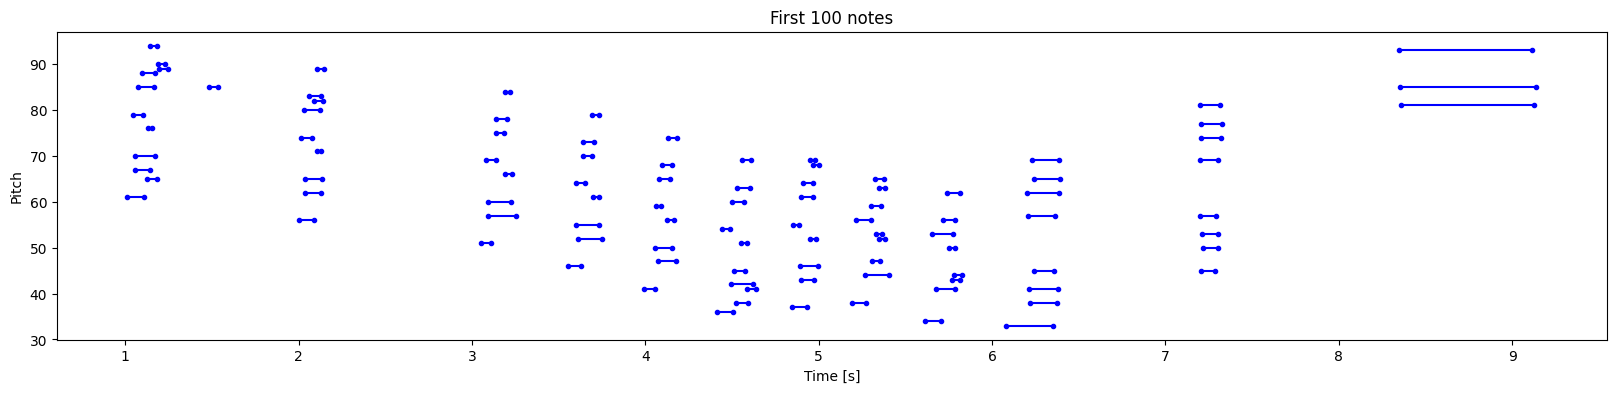

In [52]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

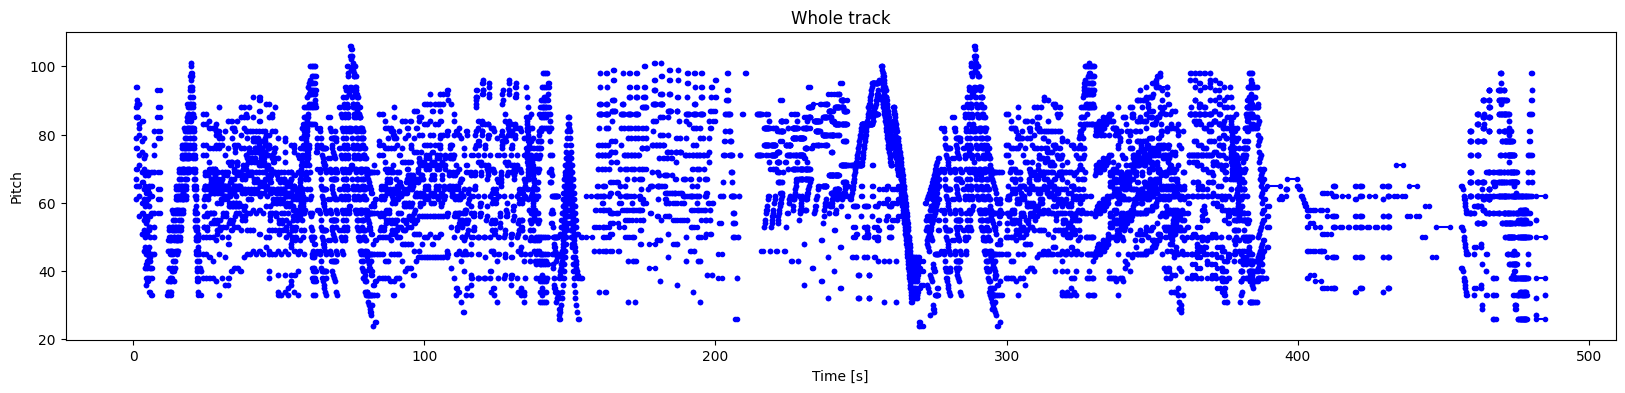

In [53]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [54]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

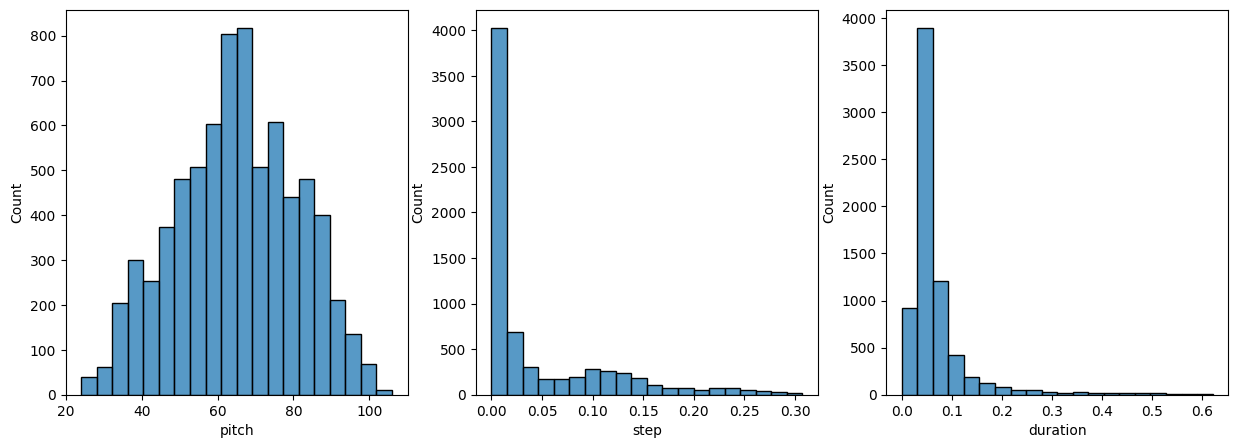

In [55]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [56]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [58]:
import pretty_midi

# Assuming you have an instrument_name, for example 'Acoustic Grand Piano'
instrument_name = 'Acoustic Grand Piano'

# Assuming you have raw_notes as a list of dictionaries containing note information
raw_notes = [
    {'pitch': 60, 'start': 0.0, 'end': 0.5, 'velocity': 100},
    {'pitch': 62, 'start': 0.5, 'end': 1.0, 'velocity': 100}
]

# Function to convert notes to MIDI and save to file
def notes_to_midi(notes, out_file, instrument_name):
    midi_data = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0, name=instrument_name)
    for note in notes:
        instrument.notes.append(pretty_midi.Note(
            velocity=note['velocity'],
            pitch=note['pitch'],
            start=note['start'],
            end=note['end']
        ))
    midi_data.instruments.append(instrument)
    midi_data.write(out_file)

# Call the function with the provided arguments
example_file = 'example.midi'
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [62]:
def display_audio(pm: pretty_midi.PrettyMIDI, soundfont_path, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE, sf2_path=soundfont_path)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds * _SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [63]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [64]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 25328


Next, create a `tf.data.Dataset` from the parsed notes.

In [65]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [66]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [67]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [68]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [69]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.3203125  0.         0.14270833]
 [0.296875   0.00104167 0.11770833]
 [0.484375   0.021875   0.09270833]
 [0.3515625  0.05208333 0.05416667]
 [0.5078125  0.00625    0.06875   ]
 [0.390625   0.015625   0.05104167]
 [0.5390625  0.00520833 0.05729167]
 [0.578125   0.03229167 0.04895833]
 [0.5546875  0.03645833 0.046875  ]
 [0.578125   0.31875    0.04791667]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=79.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.010416666666666519>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.05624999999999991>}


Batch the examples, and configure the dataset for performance.

In [70]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [71]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [72]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [73]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [74]:
losses = model.evaluate(train_ds, return_dict=True)
losses

395/395 [==============================] - 13s 17ms/step - loss: 6.0992 - duration_loss: 0.8007 - pitch_loss: 4.8509 - step_loss: 0.4476


{'loss': 6.099216461181641,
 'duration_loss': 0.8007118105888367,
 'pitch_loss': 4.850935459136963,
 'step_loss': 0.44756993651390076}

One way balance this is to use the `loss_weights` argument to compile:

In [75]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [76]:
model.evaluate(train_ds, return_dict=True)

395/395 [==============================] - 8s 17ms/step - loss: 1.4908 - duration_loss: 0.8007 - pitch_loss: 4.8509 - step_loss: 0.4476


{'loss': 1.4908291101455688,
 'duration_loss': 0.8007118105888367,
 'pitch_loss': 4.850935459136963,
 'step_loss': 0.44756993651390076}

Train the model.

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [78]:
%%time
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/5
395/395 [==============================] - 19s 48ms/step - loss: 0.3660 - duration_loss: 0.0934 - pitch_loss: 3.8994 - step_loss: 0.0777
Epoch 2/5
395/395 [==============================] - 20s 49ms/step - loss: 0.3638 - duration_loss: 0.0927 - pitch_loss: 3.8904 - step_loss: 0.0766
Epoch 3/5
395/395 [==============================] - 20s 50ms/step - loss: 0.3616 - duration_loss: 0.0921 - pitch_loss: 3.8982 - step_loss: 0.0745
Epoch 4/5
395/395 [==============================] - 18s 45ms/step - loss: 0.3604 - duration_loss: 0.0925 - pitch_loss: 3.8993 - step_loss: 0.0729
Epoch 5/5
395/395 [==============================] - 18s 45ms/step - loss: 0.3601 - duration_loss: 0.0911 - pitch_loss: 3.8826 - step_loss: 0.0749
CPU times: user 2min 3s, sys: 7.41 s, total: 2min 10s
Wall time: 1min 35s


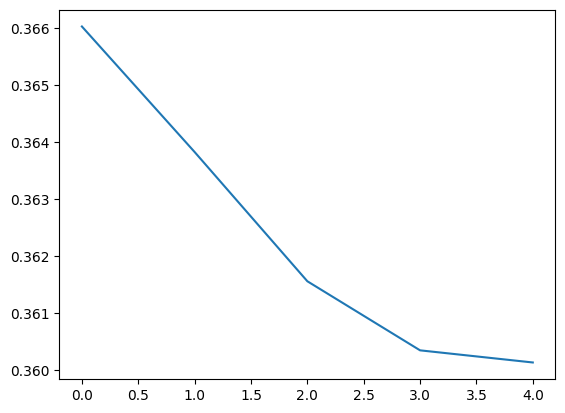

In [79]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [80]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [82]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

TypeError: list indices must be integers or slices, not str

In [83]:
generated_notes.head(10)

NameError: name 'generated_notes' is not defined

In [43]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

NameError: name 'notes_to_midi' is not defined

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

In [44]:
plot_piano_roll(generated_notes)

NameError: name 'plot_piano_roll' is not defined

Check the distributions of `pitch`, `step` and `duration`.

In [45]:
plot_distributions(generated_notes)

NameError: name 'plot_distributions' is not defined

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


In [ ]:
# Last week worked on a pre-trained model
# calulated metircs of FAD, CLAP

# Need to focus on mousai paper which has
# dataset of 50K text to music with 2500 hours music length
# able to train and collect the samples of 400 audio files which is nearly 0.8%
# 0.015% dataset currently using